# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit a neural network based model using TensorFlow.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Attempt the following architectures:
    * Single layer
    * One hidden layer
        * Same size as input layer
        * Size = Mean(Input, Output)
* Use validation curves to tune hyper parameters:
    * Learning Rate
    * Number of Steps
    * Dropout
    * Batch Size

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit
import itertools

import tensorflow as tf
import tensorflow.contrib.learn as skflow

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

## Generate validation set

In [6]:
nn_predictors = [0,3,1,5,2,8,4,19]

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(gX_train[:, nn_predictors], gy_train, test_size=0.33)
test_dataset = gX_test[:, nn_predictors]
test_labels  = gy_test

In [7]:
print train_dataset.shape, valid_dataset.shape, train_labels.shape, valid_labels.shape

(89147, 8) (43909, 8) (89147,) (43909,)


# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [23]:
def test_scores(Xtrain, ytrain, Xtest, ytest, learning_rate, hidden_units, dropout, steps, batch_size):
    """
    Generate train and test scores for selected neural network.

    Parameters
    ----------
    Xtrain : array-like, shape (n_samples, n_features)
              Training vector, where n_samples is the number of samples and
              n_features is the number of features.

    ytrain : array-like, true/expected values for training set
    
    Xtest : array-like, shape (n_samples, n_features)
             Test vector, where n_samples is the number of samples and
             n_features is the number of features.

    ytest : array-like, true/expected values for test set
  
    learning_rate : self explanatory
    
    hidden_units : self explanatory
    
    dropout : self explanatory
    
    steps : self explanatory
    
    batch_size : self explanatory

    """

    # Setup optimizer, regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                    optimizer=optimizer,
                                    dropout=float(dropout)
                                   )

    # Fit
    regressor.fit(Xtrain, 
                  ytrain,
                  steps=steps,
                  batch_size=batch_size
                 )

    # Predict and score
    train_prediction = target_scaler.inverse_transform(regressor.predict(Xtrain))
    test_prediction  = target_scaler.inverse_transform(regressor.predict(Xtest))

    print_score(X_train['gap'], train_prediction, 
                X_test['gap'], test_prediction
               )
    

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

## Generate Validation Curves

In [10]:
def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(X, y, 
                          param_name, param_range,
                          learning_list, hidden_list, dropout_list, steps_list, batch_list, 
                          plot_title, x_label, y_label):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : name of the hyper parameter that is being tested
    
    param_range : range of the hyper parameter
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 3 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=3, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    
    train_scores, test_scores = validation_curvenn(X, 
                                                   y,
                                                   cv,
                                                   learning_list,
                                                   hidden_list, 
                                                   dropout_list, 
                                                   steps_list, 
                                                   batch_list
                                                  )
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
        
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:9.2f}\tTrain Score: {2:.3f}\tCV Score: {3:.3f}' .format(param_name, float(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()
    
def validation_curvenn(X, y, cv, learning_list, hidden_list, dropout_list, steps_list, batch_list):
    """
    Generate train and validation scores for provided hyperparameter range.

    Parameters
    ----------
    estimator : tensor flow object that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, true/expected values

    cv : cross validation function to use
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes

    """
    train_scores = []
    cv_scores = []

    # Iterate over list of hyper parameters
    for learning_rate, hidden_units, dropout, steps, batch_size in itertools.product(learning_list, hidden_list, 
                                                                                     dropout_list, steps_list, batch_list):
    
        print ('Learning Rate: {0:}\tHidden Units: {1:}\tDropout: {2:}\tSteps: {3:6d}\tBatch Size: {4:5d}'
               .format(learning_rate, hidden_units, float(dropout), steps, batch_size))
        
        # Set up optimizer, regressor
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                        optimizer=optimizer, 
                                        dropout=float(dropout)
                                       )
    
        train_scores_set = []
        cv_scores_set = []
        
        # Fit and generate scores
        for train_index, cv_index in cv:
            regressor.fit(X[train_index],
                          y[train_index],
                          steps=steps, 
                          batch_size=batch_size)
    
            # Predict and score
            train_prediction = regressor.predict(X[train_index])
            train_score = metrics.mean_squared_error(train_prediction, y[train_index])
            train_scores_set.append(train_score)
        
            cv_prediction = regressor.predict(X[cv_index])
            cv_score = metrics.mean_squared_error(cv_prediction, y[cv_index])
            cv_scores_set.append(cv_score)
        
        train_scores.append(train_scores_set)
        cv_scores.append(cv_scores_set)
    
    return(train_scores,cv_scores)

# No Hidden Layers

## Validation Curves

### Number of Steps

Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:    100	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:   1000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  10000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  50000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  75000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps: 100000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps: 300000	Batch Size:  6000
Validation Curves Runtime: 1h:01m:04s


Steps:    100.00	Train Score: 0.570	CV Score: 0.579
Steps:   1000.00	Train Score: 0.459	CV Score: 0.471
Steps:  10000.00	Train Score: 0.287	CV Score: 0.295
Steps:  30000.00	Train Score: 0.228	CV Score: 0.225
Steps:  50000.00	Train Score: 0.199	CV Score: 0.192
Steps:  75000.00	Train Score

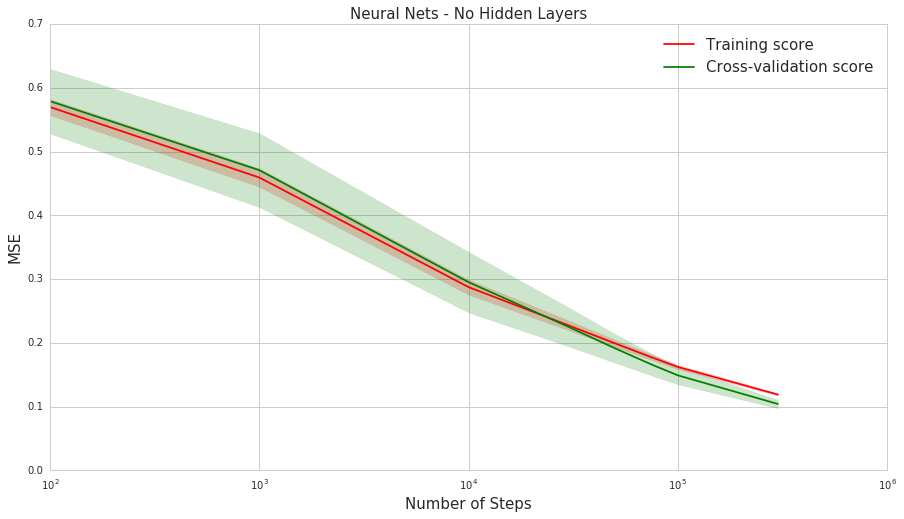

In [14]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Steps', 
                      param_range=[100,1000,10000,30000,50000,75000,100000,300000],
                      learning_list=[1e-4], 
                      hidden_list=[[]], 
                      dropout_list=[0], 
                      steps_list=[100,1000,10000,30000,50000,75000,100000,300000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Number of Steps', 
                      y_label='MSE')

We will pick 30000 as the number of steps for use in the remaining experiments. Beyond this number, the score continues to improve... however the training & CV scores diverge. Also, the runtime increases significantly as we increase the number of steps to 300000.

### Learning Rate

Learning Rate: 0.1	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 1e-05	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 1e-06	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 1e-07	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Validation Curves Runtime: 0h:23m:03s


Learning Rate:      0.10	Train Score: 0.096	CV Score: 0.087
Learning Rate:      0.01	Train Score: 0.095	CV Score: 0.084
Learning Rate:      0.00	Train Score: 0.119	CV Score: 0.104
Learning Rate:      0.00	Train Score: 0.228	CV Score: 0.225
Learning Rate:      0.00	Train Score: 0.375	CV Score: 0.387
Learning Rate:      0.00	Train Score: 0.532	CV Score: 0.542
Learning Rate:      0

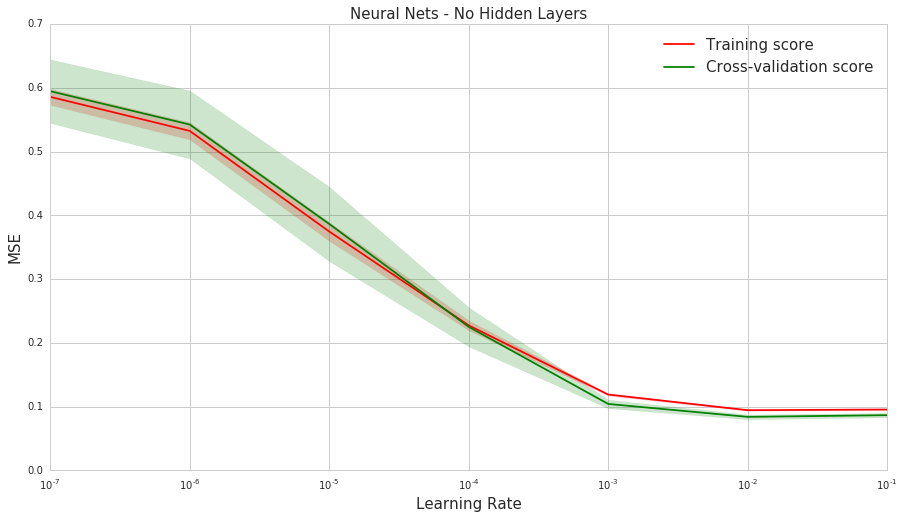

In [15]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Learning Rate', 
                      param_range=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],
                      learning_list=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7], 
                      hidden_list=[[]], 
                      dropout_list=[0], 
                      steps_list=[30000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Learning Rate', 
                      y_label='MSE')

We will pick 1e-4 as the learning rate for use in the remaining experiments. Beyond this number, the score continues to improve... however the training & CV scores diverge.

### Dropout

Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.1	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.2	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.3	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.4	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.5	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.6	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.7	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.8	Steps:  30000	Batch Size:  6000
Validation Curves Runtime: 0h:26m:17s


Dropout:      0.10	Train Score: 0.228	CV Score: 0.225
Dropout:      0.20	Train Score: 0.228	CV Score: 0.225
Dropout:      0.30	Train Score: 0.228	CV Score: 0.225
Dropout:      0.40	Train Score: 0.228	CV Score: 0.225
Dropout:      0.50	Train Score: 0.228	CV Score: 0.225
Dropout:      0.60

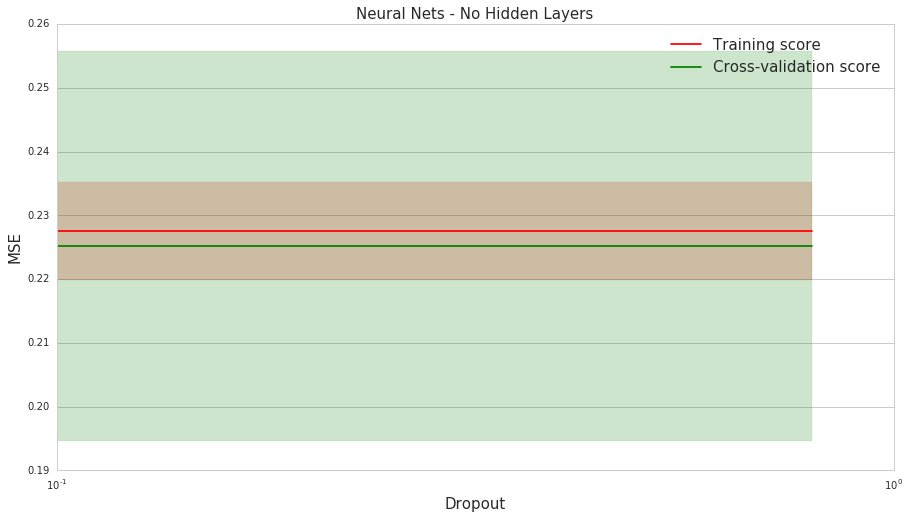

In [16]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Dropout', 
                      param_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
                      learning_list=[1e-4], 
                      hidden_list=[[]], 
                      dropout_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 
                      steps_list=[30000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Dropout', 
                      y_label='MSE')

Since dropout does not have any impact on the results, we will not use any dropout (dropout = 0).    
My conclusion is that in skflow, dropout is not used when there are no hidden units.

### Batch Size

Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  1000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  3000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size: 10000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size: 15000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size: 20000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size: 25000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size: 30000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size: 50000
Validation Curves Runtime: 0h:54m:07s


Batch Size:    300.00	Train Score: 0.228	CV Score: 0.225
Batch Size:   1000.00	Train Score: 0.228	CV Score: 0.225
Batch 

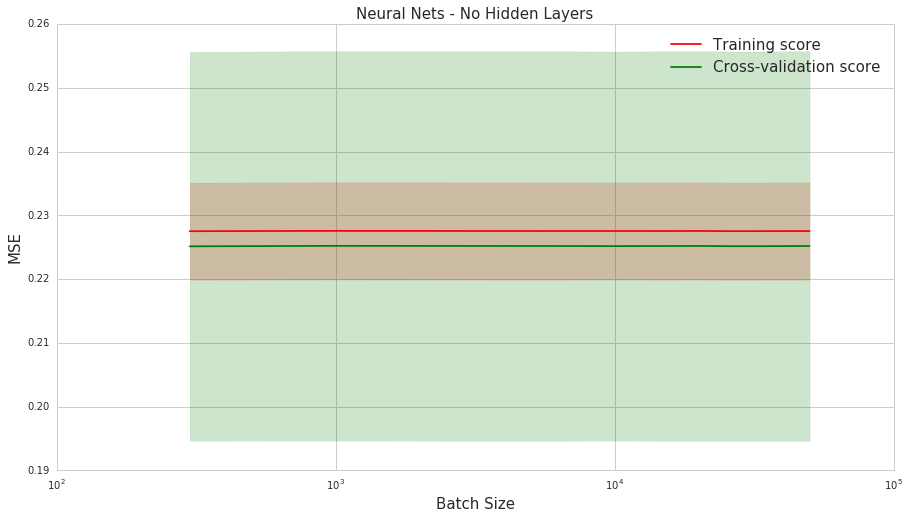

In [17]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Batch Size', 
                      param_range=[300,1000,3000,6000,10000,15000,20000,25000,30000,50000],
                      learning_list=[1e-4], 
                      hidden_list=[[]], 
                      dropout_list=[0], 
                      steps_list=[30000], 
                      batch_list=[300,1000,3000,6000,10000,15000,20000,25000,30000,50000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Batch Size', 
                      y_label='MSE'
                     )

Since batch size does not have any impact on the results, we will use a batch size of 300 which results in faster run times.    

## Test Scores

In [25]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=1e-4, 
            hidden_units=[], 
            dropout=0, 
            steps=30000, 
            batch_size=300
            )

		MEAN^2		R2		MAPE
TRAIN     	510.655		0.732		1.224
TEST      	561.268		0.757		1.263


# One Hidden Layer w/ Same Size as Input

## Baseline

In [27]:
# Generate baseline scores
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=1e-4, 
            hidden_units=[8], 
            dropout=0, 
            steps=30000, 
            batch_size=300
            )

		MEAN^2		R2		MAPE
TRAIN     	569.170		0.702		2.071
TEST      	655.767		0.716		2.118


## Validation Curves

### Learning Rate

Learning Rate: 0.06	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.03	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.006	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.003	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.001	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.0001	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 1e-05	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Validation Curves Runtime: 0h:04m:39s


Learning Rate:      0.06	Train Score: 0.524	CV Score: 0.583
Learning Rate:      0.03	Train Score: 0.101	CV Score: 0.086
Learning Rate:      0.01	Train Score: 0.103	CV Score: 0.088
Learning Rate:      0.01	Train Score: 0.106	CV Score: 0.087
Learning Rate:      0.00	Train Score: 0.100	CV Sco

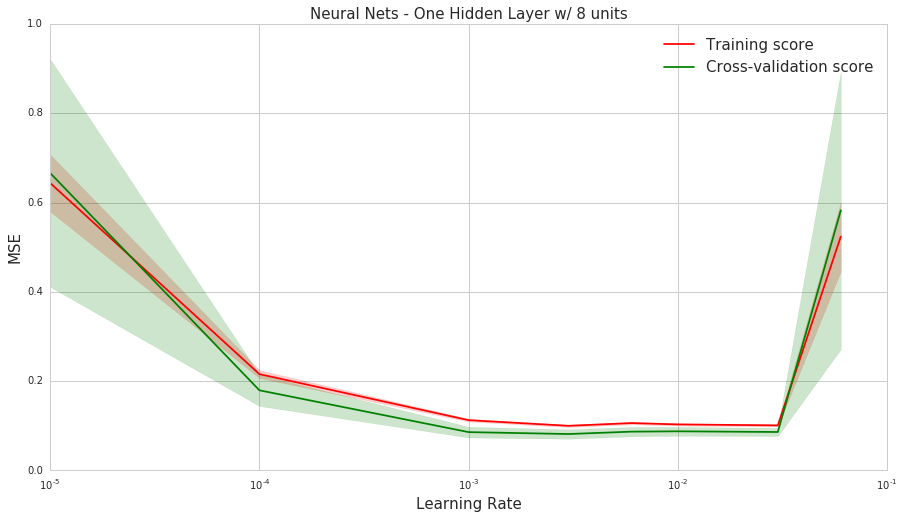

In [54]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Learning Rate', 
                      param_range=[6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5],
                      learning_list=[6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5], 
                      hidden_list=[[8]], 
                      dropout_list=[0], 
                      steps_list=[30000], 
                      batch_list=[300],
                      plot_title='Neural Nets - One Hidden Layer w/ 8 units', 
                      x_label='Learning Rate', 
                      y_label='MSE'
                     )

We will select learning rate of 0.01 that results in low training & CV scores. Learning rates higher than this lead to sharp increase in error.

### Number of Steps

Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:    100	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:   1000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:  10000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:  50000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps:  75000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps: 100000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.0	Steps: 300000	Batch Size:   300
Validation Curves Runtime: 0h:09m:52s


Number of Steps:    100.00	Train Score: 0.368	CV Score: 0.354
Number of Steps:   1000.00	Train Score: 0.144	CV Score: 0.114
Number of Steps:  10000.00	Train Score: 0.098	CV Score: 0.079
Number of Steps:  30000.00	Train Score: 0.103	CV Score: 0.088
Number of Steps:  50000.00	Train Score: 0.092	CV

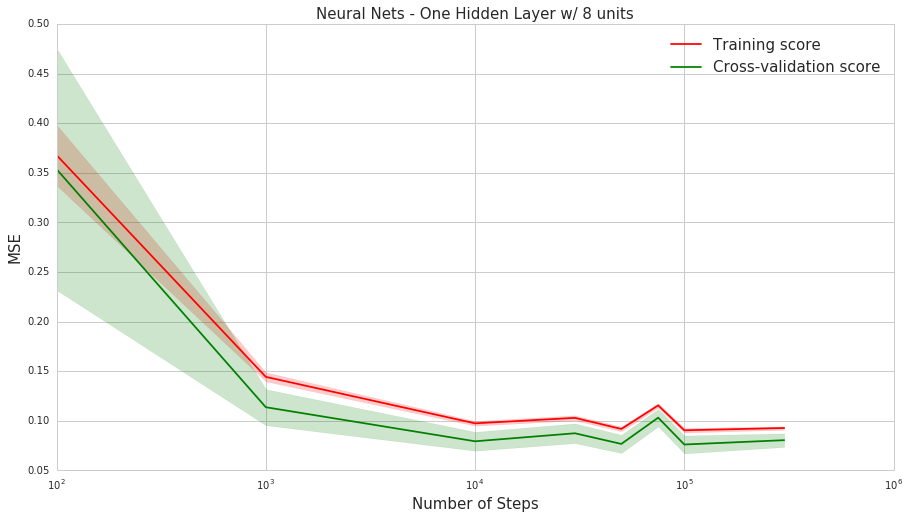

In [57]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Number of Steps', 
                      param_range=[100,1000,10000,30000,50000,75000,100000,300000],
                      learning_list=[0.01], 
                      hidden_list=[[8]], 
                      dropout_list=[0], 
                      steps_list=[100,1000,10000,30000,50000,75000,100000,300000], 
                      batch_list=[300],
                      plot_title='Neural Nets - One Hidden Layer w/ 8 units', 
                      x_label='Number of Steps', 
                      y_label='MSE'
                     )

We will select 50000 number of steps that results in low training & CV scores. Higher number of steps increase runtime without much improvement in scores.

### Dropout

Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.1	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.2	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.4	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.5	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.6	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.7	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.8	Steps:  50000	Batch Size:  6000
Validation Curves Runtime: 0h:32m:58s


Dropout:      0.10	Train Score: 0.100	CV Score: 0.078
Dropout:      0.20	Train Score: 0.103	CV Score: 0.081
Dropout:      0.30	Train Score: 0.106	CV Score: 0.084
Dropout:      0.40	Train Score: 0.113	CV Score: 0.093
Dropout:      0.50	Train Score: 0.132	CV Score: 0.113
Dropout:      0.60	Train S

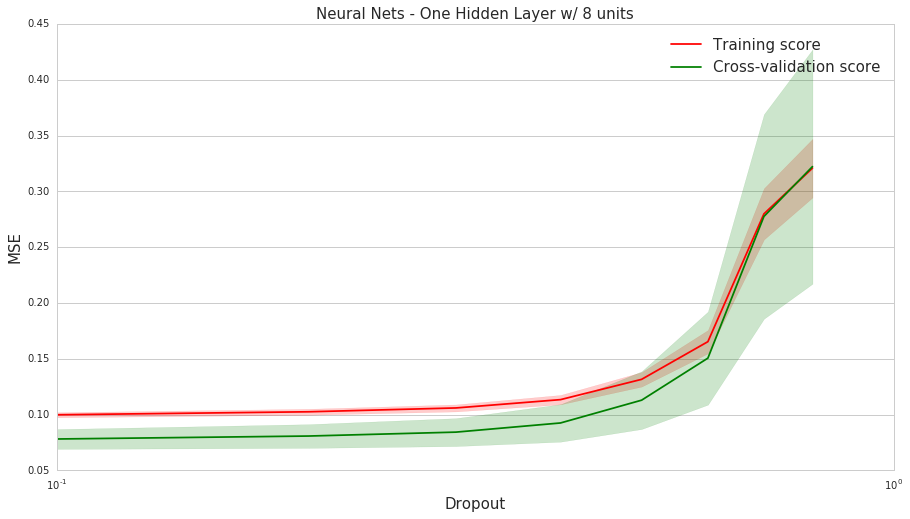

In [59]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Dropout', 
                      param_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
                      learning_list=[0.01], 
                      hidden_list=[[8]], 
                      dropout_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 
                      steps_list=[50000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - One Hidden Layer w/ 8 units', 
                      x_label='Dropout', 
                      y_label='MSE')

Lower or no dropout results in higher scores. However, using dropout ensures that the network is more robust to noise. We will select dropout of 0.3 since the scores are pretty close to the best.

### Batch Size

Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size:  1000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size:  3000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size: 10000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size: 30000
Learning Rate: 0.01	Hidden Units: [8]	Dropout: 0.3	Steps:  50000	Batch Size: 50000
Validation Curves Runtime: 0h:47m:36s


Batch Size:    300.00	Train Score: 0.108	CV Score: 0.084
Batch Size:   1000.00	Train Score: 0.114	CV Score: 0.094
Batch Size:   3000.00	Train Score: 0.106	CV Score: 0.083
Batch Size:   6000.00	Train Score: 0.106	CV Score: 0.084
Batch Size:  10000.00	Train Score: 0.108	CV Score: 0.087
Batch Size:  30000.00	Train Score: 0.106	CV Score: 0.084
Batch Size:  50000.00	Train Score: 0.

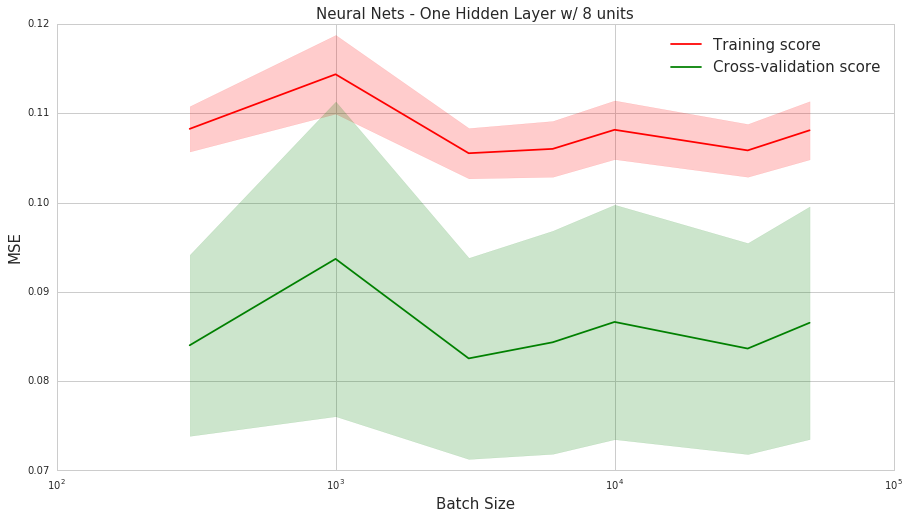

In [61]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Batch Size', 
                      param_range=[300,1000,3000,6000,10000,30000,50000],
                      learning_list=[0.01], 
                      hidden_list=[[8]], 
                      dropout_list=[0.3], 
                      steps_list=[50000], 
                      batch_list=[300,1000,3000,6000,10000,30000,50000],
                      plot_title='Neural Nets - One Hidden Layer w/ 8 units', 
                      x_label='Batch Size', 
                      y_label='MSE')

We will select 3000 for batch size since it produces good training & cv scores. Larger batch sizes lead to longer runtimes.

## Test Scores

In [28]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.01, 
            hidden_units=[8], 
            dropout=0.3, 
            steps=50000, 
            batch_size=3000
            )

		MEAN^2		R2		MAPE
TRAIN     	196.569		0.897		0.367
TEST      	334.465		0.855		0.375


# One Hidden Layer w/ Size = Mean(Input, Output)

## Baseline

In [29]:
# Generate baseline scores
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=1e-4, 
            hidden_units=[5], 
            dropout=0, 
            steps=30000, 
            batch_size=300
            )

		MEAN^2		R2		MAPE
TRAIN     	504.490		0.736		1.843
TEST      	596.815		0.742		2.207


## Validation Curves

### Learning Rate

Learning Rate: 0.06	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.03	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.006	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.003	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.001	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.0001	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 1e-05	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Validation Curves Runtime: 0h:04m:34s


Learning Rate:      0.06	Train Score: 0.529	CV Score: 0.590
Learning Rate:      0.03	Train Score: 0.104	CV Score: 0.088
Learning Rate:      0.01	Train Score: 0.107	CV Score: 0.086
Learning Rate:      0.01	Train Score: 0.115	CV Score: 0.093
Learning Rate:      0.00	Train Score: 0.109	CV Sco

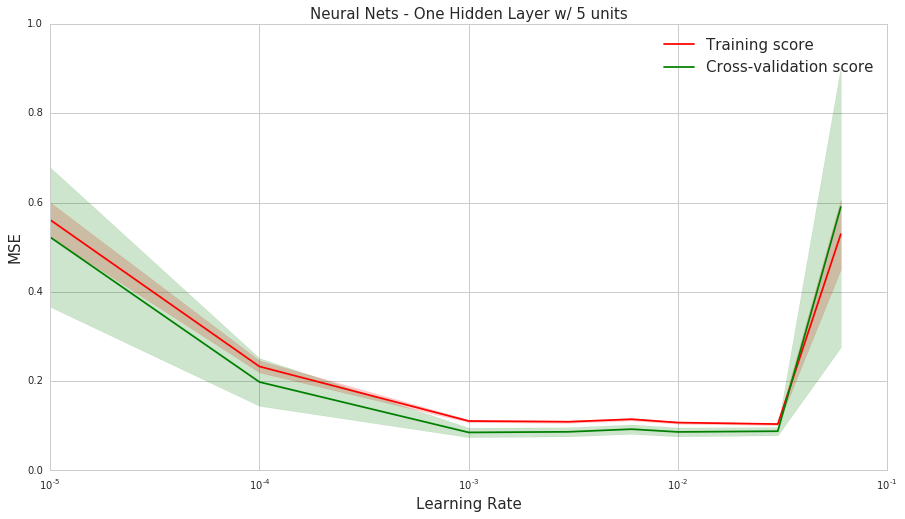

In [55]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Learning Rate', 
                      param_range=[6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5],
                      learning_list=[6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5], 
                      hidden_list=[[5]], 
                      dropout_list=[0], 
                      steps_list=[30000], 
                      batch_list=[300],
                      plot_title='Neural Nets - One Hidden Layer w/ 5 units', 
                      x_label='Learning Rate', 
                      y_label='MSE'
                     )

We will select learning rate of 0.01 that results in low training & CV scores. Learning rates higher than this lead to sharp increase in error.

### Number of Steps

Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps:  10000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps:  30000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps: 100000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps: 600000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.0	Steps: 1000000	Batch Size:   300
Validation Curves Runtime: 0h:31m:23s


Number of Steps:  10000.00	Train Score: 0.109	CV Score: 0.087
Number of Steps:  30000.00	Train Score: 0.102	CV Score: 0.083
Number of Steps: 100000.00	Train Score: 0.091	CV Score: 0.077
Number of Steps: 300000.00	Train Score: 0.085	CV Score: 0.083
Number of Steps: 600000.00	Train Score: 0.086	CV Score: 0.085
Number of Steps: 1000000.00	Train Score: 0.082	CV Score: 0.084


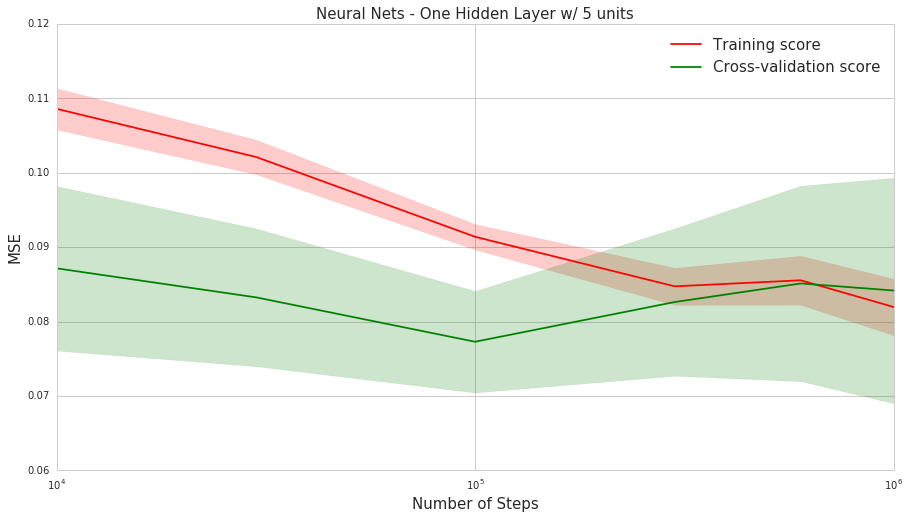

In [58]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Number of Steps', 
                      param_range=[10000,30000,100000,300000,600000,1000000],
                      learning_list=[0.01], 
                      hidden_list=[[5]], 
                      dropout_list=[0], 
                      steps_list=[10000,30000,100000,300000,600000,1000000], 
                      batch_list=[300],
                      plot_title='Neural Nets - One Hidden Layer w/ 5 units', 
                      x_label='Number of Steps', 
                      y_label='MSE'
                     )

We will select 300000 as number of steps - this results in low training & CV scores. Higher number of steps increase runtime without much improvement in scores.

### Dropout

Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.1	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.3	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.4	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.5	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.65	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.7	Steps: 300000	Batch Size:   300
Validation Curves Runtime: 0h:32m:24s


Dropout:      0.10	Train Score: 0.101	CV Score: 0.079
Dropout:      0.20	Train Score: 0.118	CV Score: 0.097
Dropout:      0.30	Train Score: 0.188	CV Score: 0.170
Dropout:      0.40	Train Score: 0.354	CV Score: 0.351
Dropout:      0.50	Train Score: 0.107	CV Score: 0.086
Dropout:      0.65	Train Score: 0.464	CV Score: 0.482
Dropout:      0.70	Train Score: 0.961	CV Score: 1.040


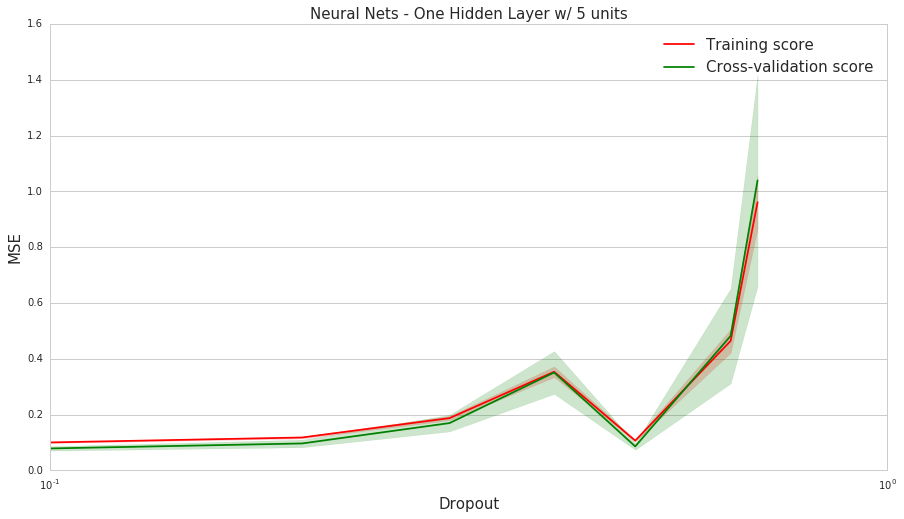

In [64]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Dropout', 
                      param_range=[0.1,0.2,0.3,0.4,0.5,0.65,0.7],
                      learning_list=[0.01], 
                      hidden_list=[[5]], 
                      dropout_list=[0.1,0.2,0.3,0.4,0.5,0.65,0.7], 
                      steps_list=[300000], 
                      batch_list=[300],
                      plot_title='Neural Nets - One Hidden Layer w/ 5 units', 
                      x_label='Dropout', 
                      y_label='MSE')

Lower or no dropout results in higher scores. However, using dropout ensures that the network is more robust to noise. We will select dropout of 0.2 since the scores are pretty close to the best.

### Batch Size

Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size:   300
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size:  1000
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size:  3000
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size: 10000
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size: 30000
Learning Rate: 0.01	Hidden Units: [5]	Dropout: 0.2	Steps: 300000	Batch Size: 50000
Validation Curves Runtime: 4h:16m:08s


Batch Size:    300.00	Train Score: 0.118	CV Score: 0.097
Batch Size:   1000.00	Train Score: 0.106	CV Score: 0.085
Batch Size:   3000.00	Train Score: 0.104	CV Score: 0.083
Batch Size:   6000.00	Train Score: 0.103	CV Score: 0.082
Batch Size:  10000.00	Train Score: 0.103	CV Score: 0.080
Batch Size:  30000.00	Train Score: 0.105	CV Score: 0.083
Batch Size:  50000.00	Train Score: 0.

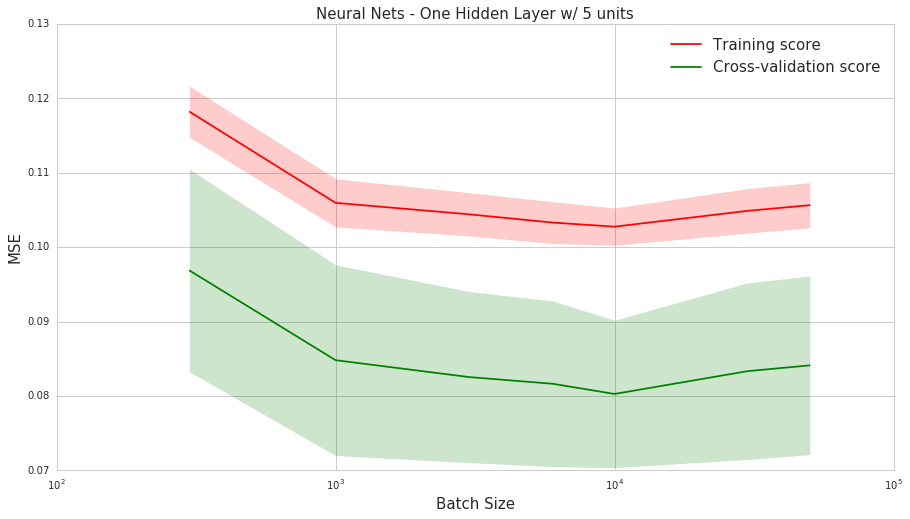

In [65]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Batch Size', 
                      param_range=[300,1000,3000,6000,10000,30000,50000],
                      learning_list=[0.01], 
                      hidden_list=[[5]], 
                      dropout_list=[0.2], 
                      steps_list=[300000], 
                      batch_list=[300,1000,3000,6000,10000,30000,50000],
                      plot_title='Neural Nets - One Hidden Layer w/ 5 units', 
                      x_label='Batch Size', 
                      y_label='MSE')

We will select 3000 for batch size since it produces good training & cv scores. Larger batch sizes lead to longer runtimes.

## Test Scores

In [30]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.01, 
            hidden_units=[5], 
            dropout=0.2, 
            steps=300000, 
            batch_size=3000
            )

		MEAN^2		R2		MAPE
TRAIN     	202.191		0.894		0.353
TEST      	348.322		0.849		0.435
